In [1]:
from atomsci.ddm.pipeline import compare_models as cm
from atomsci.ddm.pipeline import hyper_perf_plots as hpp
from atomsci.ddm.pipeline import perf_plots as pp
import pandas as pd
pd.set_option('display.max_columns', None)

# ignore warnings in tutorials
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

Skipped loading some Jax models, missing a dependency. No module named 'haiku'
/opt/anaconda3/envs/atomsci-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Read in the example dataframe 

result_df=pd.read_csv('dataset/SLC6A3_models/07_example_pred_df.csv', index_col=0)

result_df=result_df.sort_values('best_valid_r2_score', ascending=False)

In [3]:
# Model counts for each splitter
model_counts=pd.DataFrame(result_df.groupby(['features','splitter','model_type'])['model_uuid'].count()).reset_index()
model_counts=model_counts.pivot(index='model_type',columns=['splitter','features',], values='model_uuid')
model_counts

splitter,fingerprint,scaffold,fingerprint,scaffold
features,ecfp,ecfp,rdkit_raw,rdkit_raw
model_type,,,,
NN,26,29,25,96
RF,30,30,30,32
xgboost,47,26,20,76


In [4]:
# filter out objectively bad performing models
result_df=result_df[result_df.best_valid_r2_score>0.1]
result_df.shape

(264, 41)

In [5]:
#  model counts
model_counts=pd.DataFrame(result_df.groupby(['features','splitter','model_type'])['model_uuid'].count()).reset_index()
model_counts=model_counts.pivot(index='model_type',columns=['splitter','features',], values='model_uuid')
model_counts

splitter,fingerprint,scaffold,fingerprint,scaffold
features,ecfp,ecfp,rdkit_raw,rdkit_raw
model_type,,,,
NN,8.0,23.0,11.0,86.0
RF,NaN,30.0,NaN,32.0
xgboost,3.0,21.0,NaN,50.0


So the filtering removed [18 fingerprint ecfp NN], [30 fingerpint ecfp RF], [44 fingerpring ecfp xgboost], [6 scaffold ecfp NN], [5 scaffold ecfp xgboost], [14 fingerprint rdkit_raw NN], [30 fingerpring rdkit_raw RF], [20 fingerpring rdkit_raw xgboost], [10 scaffold rdkit_raw NN], [26 scaffold rdkit_raw xgboost]

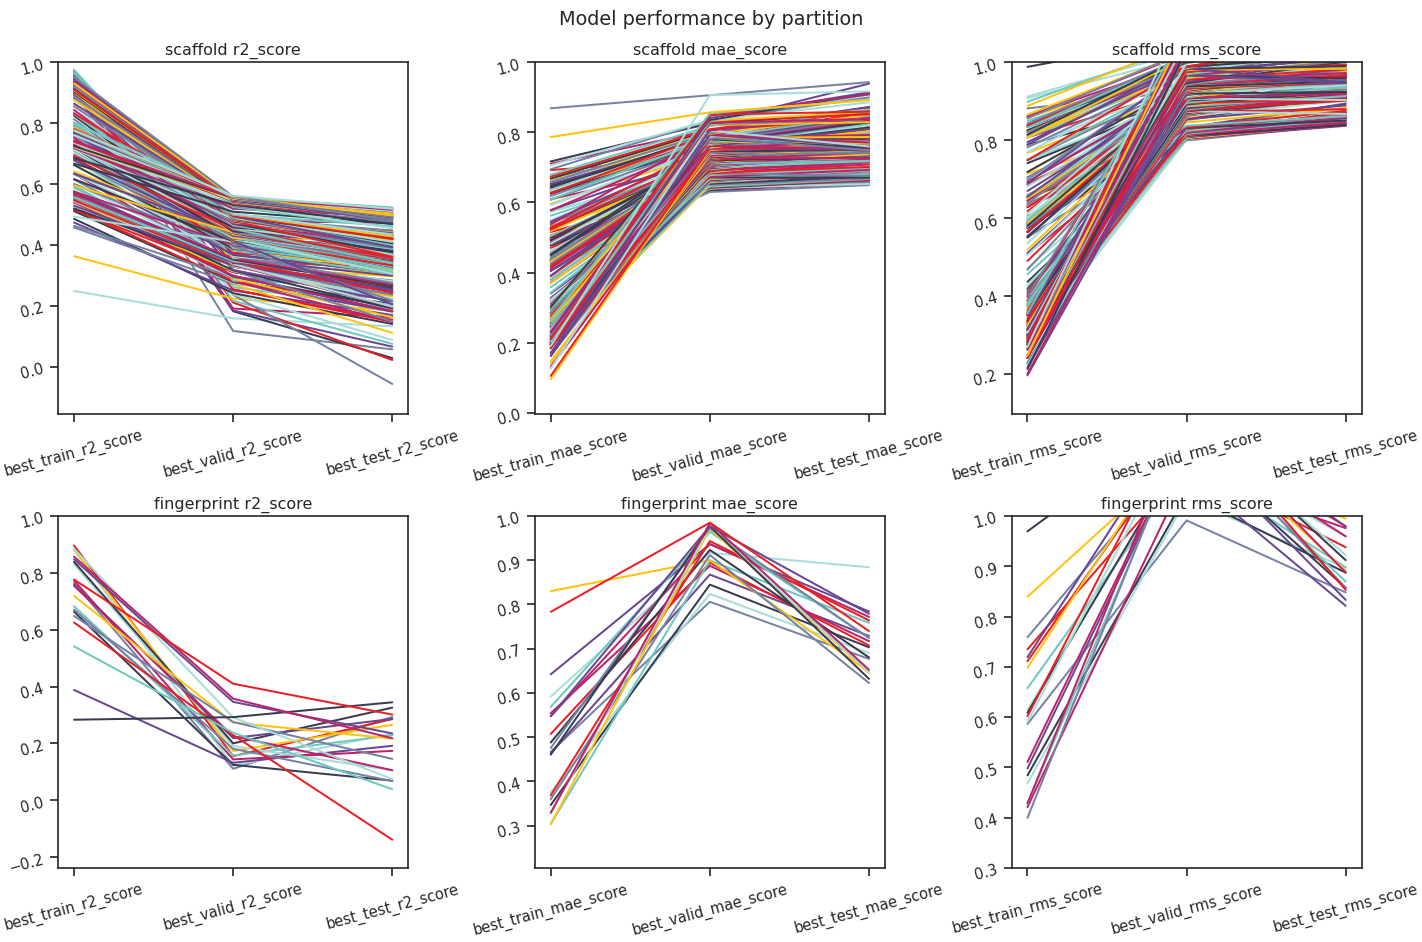

In [6]:
hpp.plot_train_valid_test_scores(result_df, prediction_type='regression')

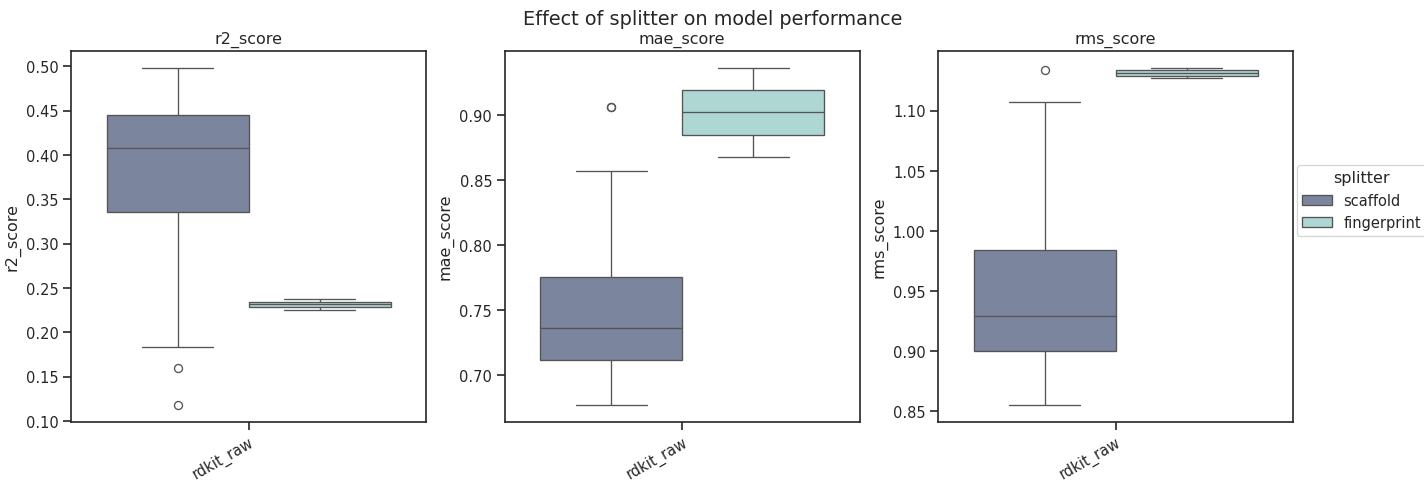

In [7]:
hpp.plot_split_perf(result_df, subset='valid')

In [10]:
import numpy as np

In [8]:
# Break down the plot split perf
df=result_df
perf_track_df=df.copy()

In [11]:
if 'NN' in perf_track_df.model_type.unique():
    perf_track_df['plot_dropout'] = perf_track_df.dropouts.astype(str).str.strip('[]').str.split(pat=',',n=1, expand=True)[0]
    perf_track_df['plot_dropout'] = perf_track_df.plot_dropout.astype(float)
    perf_track_df['layer_sizes'] = perf_track_df.layer_sizes.astype(str).str.strip('[]')
    cols=['dummy_nodes_1','dummy_nodes_2','dummy_nodes_3']
    tmp=perf_track_df.layer_sizes.str.split(pat=',', expand=True).astype(float)
    n=len(tmp.columns)
    perf_track_df[cols[0:n]]=tmp
    perf_track_df['num_layers'] = n-perf_track_df[cols[0:n]].isna().sum(axis=1)
    perf_track_df[cols[0:n]]=perf_track_df[cols[0:n]].fillna(value=1).astype(int)
    perf_track_df['num_nodes']=perf_track_df[cols[0:n]].product(axis=1)
    perf_track_df=perf_track_df.drop(columns=cols[0:n])
    perf_track_df.loc[perf_track_df.model_type != "NN", 'layer_sizes']=np.nan
    perf_track_df.loc[perf_track_df.model_type != "NN", 'num_layers']=np.nan
    perf_track_df.loc[perf_track_df.model_type != "NN", 'num_nodes']=np.nan
    perf_track_df.loc[perf_track_df.model_type != "NN", 'plot_dropout']=np.nan

In [16]:
perf_track_df=perf_track_df.reset_index(drop=True)

In [18]:
import seaborn as sns 
sns.set_style("ticks")
sns.set_context("paper")

In [20]:
scoretype='r2_score'
subset='valid'

In [21]:
winnertype= f'best_{subset}_{scoretype}'

In [24]:
colors = ["#7682A4","#A7DDD8","#373C50","#694691","#BE2369","#EB1E23","#6EC8BE","#FFC30F",]
# Set your custom color palette
pal=sns.color_palette(colors)
sns.set_palette(pal)

regselmets=[
 'r2_score',
 'mae_score',
 'rms_score',
]
classselmets = [
 'roc_auc_score',
 'prc_auc_score',
 'precision',
 'recall_score',
 'npv',
 'accuracy_score',
 'kappa',
 'matthews_cc',
 'bal_accuracy',
]
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
if scoretype in regselmets:
    selmets=regselmets
elif scoretype in classselmets:
    selmets=classselmets

In [30]:
plot_df=perf_track_df

In [31]:
plot_df=plot_df.sort_values('features')

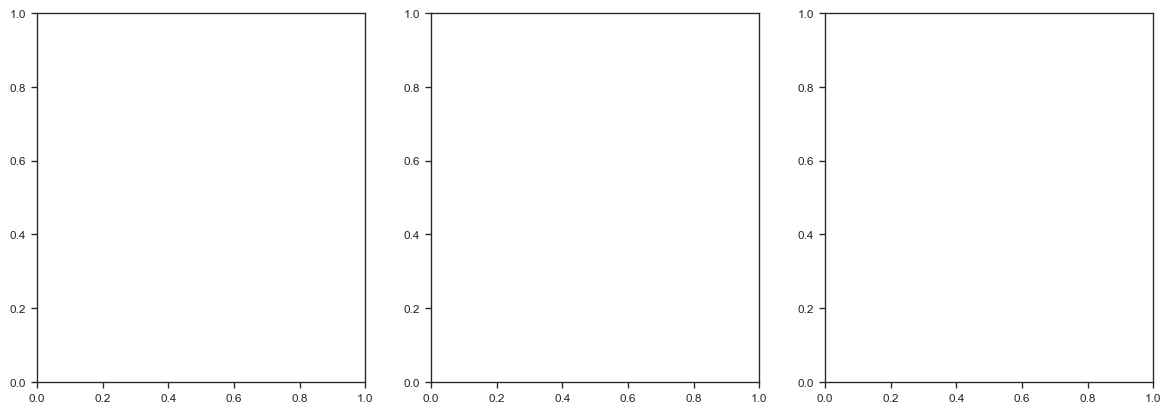

In [33]:
fig, axes = plt.subplots(1,len(selmets), figsize=(5*len(selmets),5))

In [34]:
plot_df

,model_uuid,model_path,ampl_version,model_type,dataset_key,features,splitter,split_strategy,split_uuid,model_score_type,feature_transform_type,model_choice_score,best_train_r2_score,best_train_rms_score,best_train_mae_score,best_train_num_compounds,best_valid_r2_score,best_valid_rms_score,best_valid_mae_score,best_valid_num_compounds,best_test_r2_score,best_test_rms_score,best_test_mae_score,best_test_num_compounds,rf_estimators,rf_max_features,rf_max_depth,max_epochs,best_epoch,learning_rate,layer_sizes,dropouts,xgb_gamma,xgb_learning_rate,xgb_max_depth,xgb_colsample_bytree,xgb_subsample,xgb_n_estimators,xgb_min_child_weight,model_parameters_dict,feat_parameters_dict,plot_dropout,num_layers,num_nodes
0,b24a2887-8eca-43e2-8fc2-3642189d2c94,dataset/SLC6A3_models/SLC6A3_Ki_curated_model_...,1.6.0,NN,/home/apaulson/repos/AMPL_umbrella/AMPL/atomsc...,ecfp,scaffold,train_valid_test,c35aeaab-910c-4dcf-8f9f-04b55179aa1a,r2,normalization,0.562091,0.776865,0.585176,0.432550,1273,0.562091,0.799156,0.629897,273,0.519325,0.840682,0.649599,273,NaN,NaN,NaN,100.0,24.0,0.000083,"369,283,146","0.28,0.30,0.30",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""best_epoch"": 24, ""dropouts"": [0.278664215998...","{""ecfp_radius"": 2, ""ecfp_size"": 1024}",0.28,3.0,15246342.0
85,5d4d523a-5866-4f7f-954f-86e5a9c8cb36,dataset/SLC6A3_models/SLC6A3_Ki_curated_model_...,1.6.0,RF,/home/apaulson/repos/AMPL_umbrella/AMPL/atomsc...,ecfp,scaffold,train_valid_test,c35aeaab-910c-4dcf-8f9f-04b55179aa1a,r2,normalization,0.472790,0.728863,0.645055,0.525793,1273,0.472790,0.876862,0.718010,273,0.447453,0.901344,0.745272,273,89.0,46.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""rf_estimators"": 89, ""rf_max_depth"": 9, ""rf_m...","{""ecfp_radius"": 2, ""ecfp_size"": 1024}",NaN,NaN,NaN
81,746ea8da-8fbf-4ae6-9815-585e3431339b,dataset/SLC6A3_models/SLC6A3_Ki_curated_model_...,1.6.0,NN,/home/apaulson/repos/AMPL_umbrella/AMPL/atomsc...,ecfp,scaffold,train_valid_test,c35aeaab-910c-4dcf-8f9f-04b55179aa1a,r2,normalization,0.475805,0.742435,0.628704,0.477600,1273,0.475805,0.874351,0.671194,273,0.488391,0.867311,0.670880,273,NaN,NaN,NaN,100.0,4.0,0.007539,"441,120,235","0.05,0.19,0.24",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""best_epoch"": 4, ""dropouts"": [0.0549162994563...","{""ecfp_radius"": 2, ""ecfp_size"": 1024}",0.05,3.0,12436200.0
77,4183f544-eab7-4927-891a-c674b9f674c4,dataset/SLC6A3_models/SLC6A3_Ki_curated_model_...,1.6.0,NN,/home/apaulson/repos/AMPL_umbrella/AMPL/atomsc...,ecfp,scaffold,train_valid_test,c35aeaab-910c-4dcf-8f9f-04b55179aa1a,r2,normalization,0.478562,0.904949,0.381927,0.277583,1273,0.478562,0.872050,0.682936,273,0.473759,0.879627,0.675459,273,NaN,NaN,NaN,100.0,28.0,0.002319,"92,256,500","0.38,0.30,0.39",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""best_epoch"": 28, ""dropouts"": [0.379265887682...","{""ecfp_radius"": 2, ""ecfp_size"": 1024}",0.38,3.0,11776000.0
73,fa0128fc-af70-4f72-b8d0-59cc0f6d8782,dataset/SLC6A3_models/SLC6A3_Ki_curated_model_...,1.6.0,xgboost,/home/apaulson/repos/AMPL_umbrella/AMPL/atomsc...,ecfp,scaffold,train_valid_test,c35aeaab-910c-4dcf-8f9f-04b55179aa1a,r2,normalization,0.481077,0.945607,0.288917,0.209240,1273,0.481077,0.869944,0.683397,273,0.420876,0.922766,0.729359,273,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.071062,0.429102,6.0,1.0,1.0,100.0,1.0,"{""xgb_colsample_bytree"": 1.0, ""xgb_gamma"": 0.0...","{""ecfp_radius"": 2, ""ecfp_size"": 1024}",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,f3d46d6c-8da9-4f69-beb1-2c880d82ee3e,dataset/SLC6A3_models/SLC6A3_Ki_curated_model_...,1.6.0,xgboost,/home/apaulson/repos/AMPL_umbrella/AMPL/atomsc...,rdkit_raw,scaffold,train_valid_test,c35aeaab-910c-4dcf-8f9f-04b55179aa1a,r2,normalization,0.420359,0.943838,0.293579,0.210991,1273,0.420359,0.919431,0.725736,273,0.419644,0.923747,0.726690,273,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.058842,0.204631,6.0,1.0,1.0,100.0,1.0,"{""xgb_co

/var/folders/rf/_d6b2mgd3p9f422kk977zjlh0000gn/T/ipykernel_84764/7985733.py:4: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  g=sns.boxplot(x="features", y=selection_metric, # x="txptr_features" x="model_type"
/var/folders/rf/_d6b2mgd3p9f422kk977zjlh0000gn/T/ipykernel_84764/7985733.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels( g.get_xticklabels(), rotation=30, ha='right', rotation_mode='anchor' )
/var/folders/rf/_d6b2mgd3p9f422kk977zjlh0000gn/T/ipykernel_84764/7985733.py:4: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  g=sns.boxplot(x="features", y=selection_metric, # x="txptr_features" x="model_type"
/var/folders/rf/_d6b2mgd3p9f422kk977zjlh0000gn/T/ipykernel_84764/7985733.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() o

Text(0.5, 1.01, 'Effect of splitter on model performance')

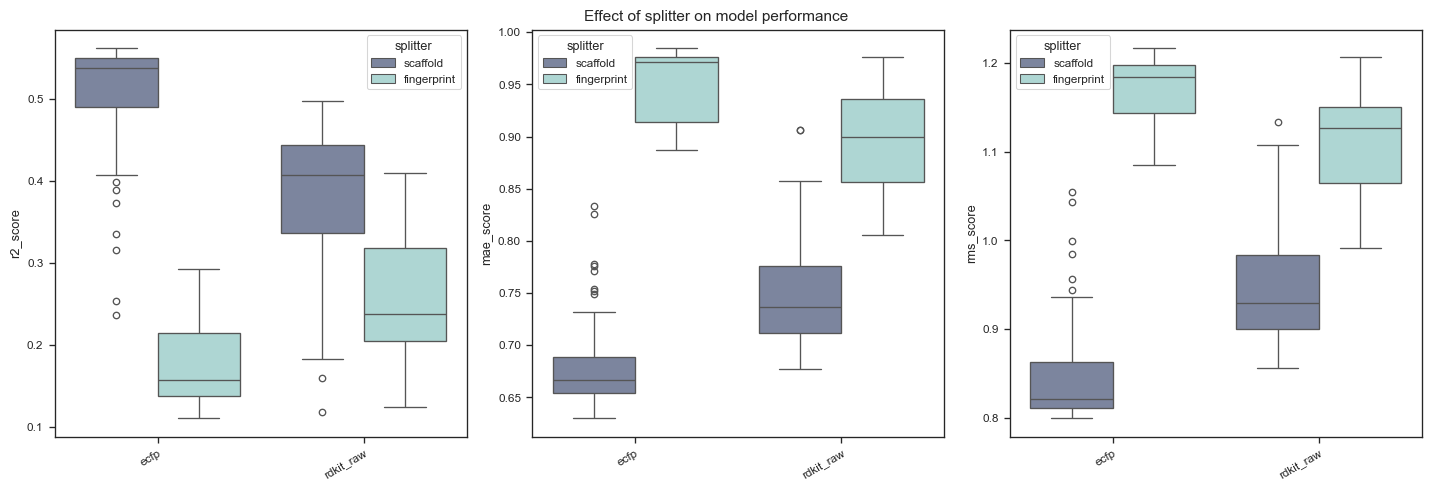

In [36]:
fig, axes = plt.subplots(1,len(selmets), figsize=(5*len(selmets),5))
for i, ax in enumerate(axes.flat):
    selection_metric = f'best_{subset}_{selmets[i]}'
    g=sns.boxplot(x="features", y=selection_metric, # x="txptr_features" x="model_type"
                hue='splitter', palette = sns.color_palette(colors), #showfliers=False, 
                data=plot_df, ax=ax);
    g.set_xlabel('')
    g.set_ylabel(selection_metric.replace('best_valid_',''))
    g.set_xticklabels( g.get_xticklabels(), rotation=30, ha='right', rotation_mode='anchor' )
plt.tight_layout()
fig.suptitle('Effect of splitter on model performance', y=1.01)

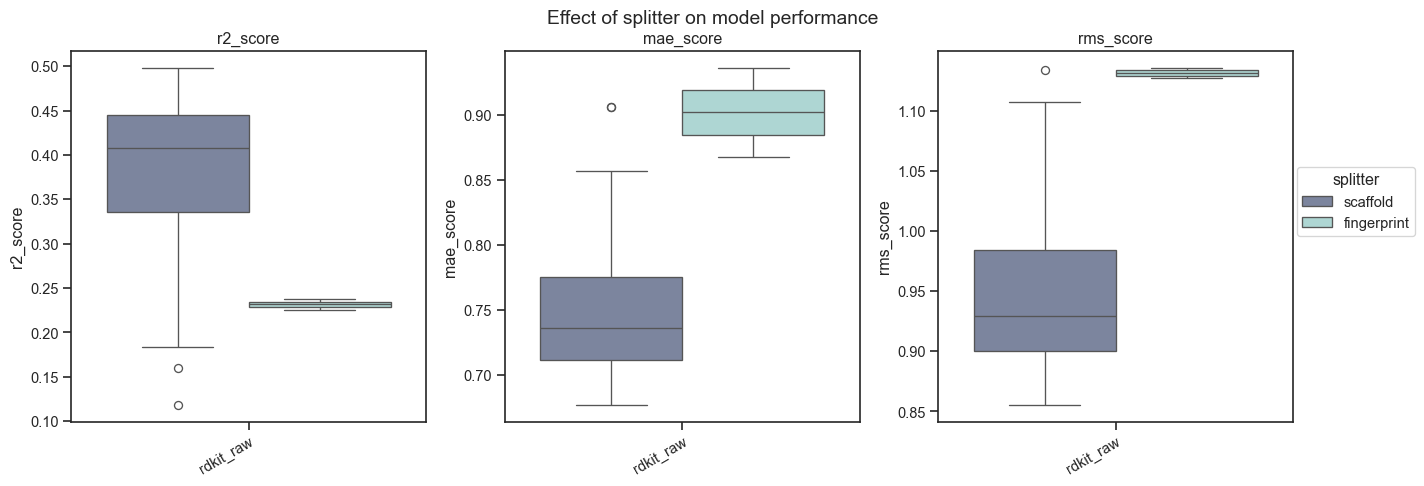

In [39]:
hpp.plot_split_perf(result_df,subset='valid')

## Implementing the version from 1.6.1

In [41]:
# score types
regselmets=[
 'r2_score',
 'mae_score',
 'rms_score',
]
classselmets = [
 'roc_auc_score',
 'prc_auc_score',
 'precision',
 'recall_score',
 'npv',
 'accuracy_score',
 'kappa',
 'matthews_cc',
 'bal_accuracy',
]


In [42]:
prediction_type='regression'
subset='valid'

In [43]:
if prediction_type=='regression':
    selmets=regselmets
elif prediction_type=='classification':
    selmets=classselmets

In [44]:
plot_df=perf_track_df
plot_df=plot_df.sort_values('features')

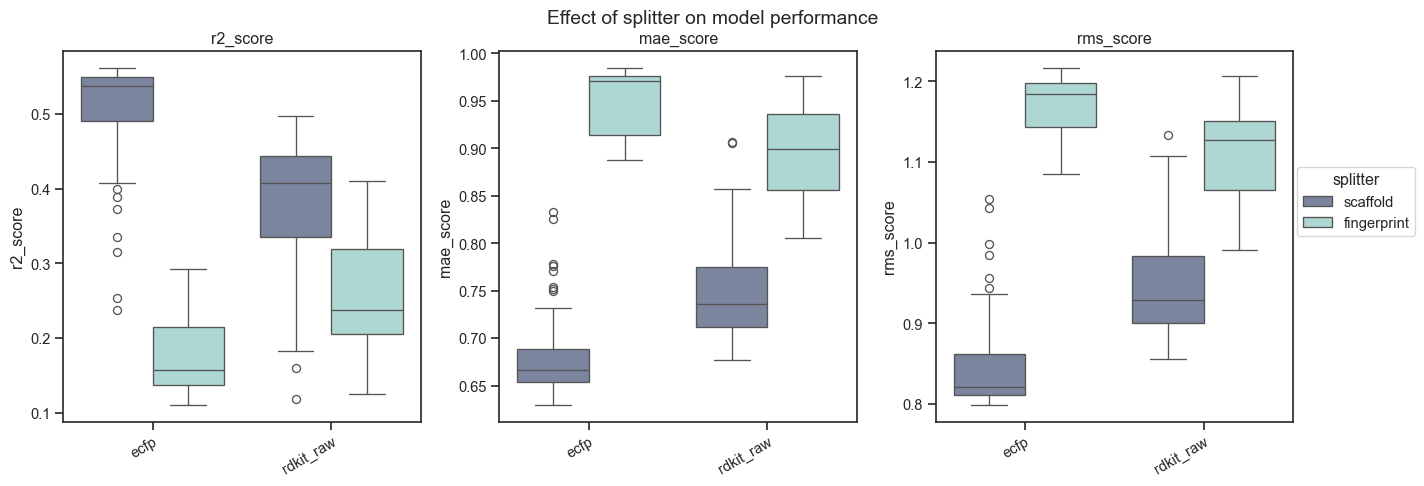

In [45]:
with sns.axes_style("ticks"):
    fig, axes = plt.subplots(1,len(selmets), figsize=(5*len(selmets),5))
    for i, ax in enumerate(axes.flat):
        if i==len(axes.flat)-1:
            legend=True
        else:
            legend=False
        selection_metric = f'best_{subset}_{selmets[i]}'
        sns.boxplot(x="features", y=selection_metric, # x="txptr_features" x="model_type"
                    hue='splitter', palette = sns.color_palette(colors[0:plot_df.splitter.nunique()]), #showfliers=False, 
                    legend=legend,
                    data=plot_df, ax=ax);
        ax.set_xlabel('')
        ax.set_ylabel(selection_metric.replace(f'best_{subset}_',''))
        ax.set_xticks(ax.get_xticks()) # avoid warning by including this line
        ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right', rotation_mode='anchor' )
        ax.set_title(selection_metric.replace(f'best_{subset}_',''))
        if legend: sns.move_legend(ax, loc=(1.01,0.5))
    plt.tight_layout()
    fig.suptitle('Effect of splitter on model performance', y=1.01)


# Looking into the Scatter Plot
I'm hypothesizing it is something to do with a change in the command used to create the plot: `plot_pred_vs_actual_from_file`. 

I want to use the code from AMPL 1.6.0 to see if it produces something similar to what's seen in the github notebooks

## The original scatter plot

2024-05-28 13:31:18,112 dataset/SLC6A3_models/SLC6A3_Ki_curated_model_b24a2887-8eca-43e2-8fc2-3642189d2c94.tar.gz, 1.6.0
2024-05-28 13:31:18,114 Version compatible check: dataset/SLC6A3_models/SLC6A3_Ki_curated_model_b24a2887-8eca-43e2-8fc2-3642189d2c94.tar.gz version = "1.6", AMPL version = "1.6"


['/var/folders/rf/_d6b2mgd3p9f422kk977zjlh0000gn/T/tmpmt9iax69/best_model/checkpoint1.pt']
/var/folders/rf/_d6b2mgd3p9f422kk977zjlh0000gn/T/tmpmt9iax69/best_model/checkpoint1.pt


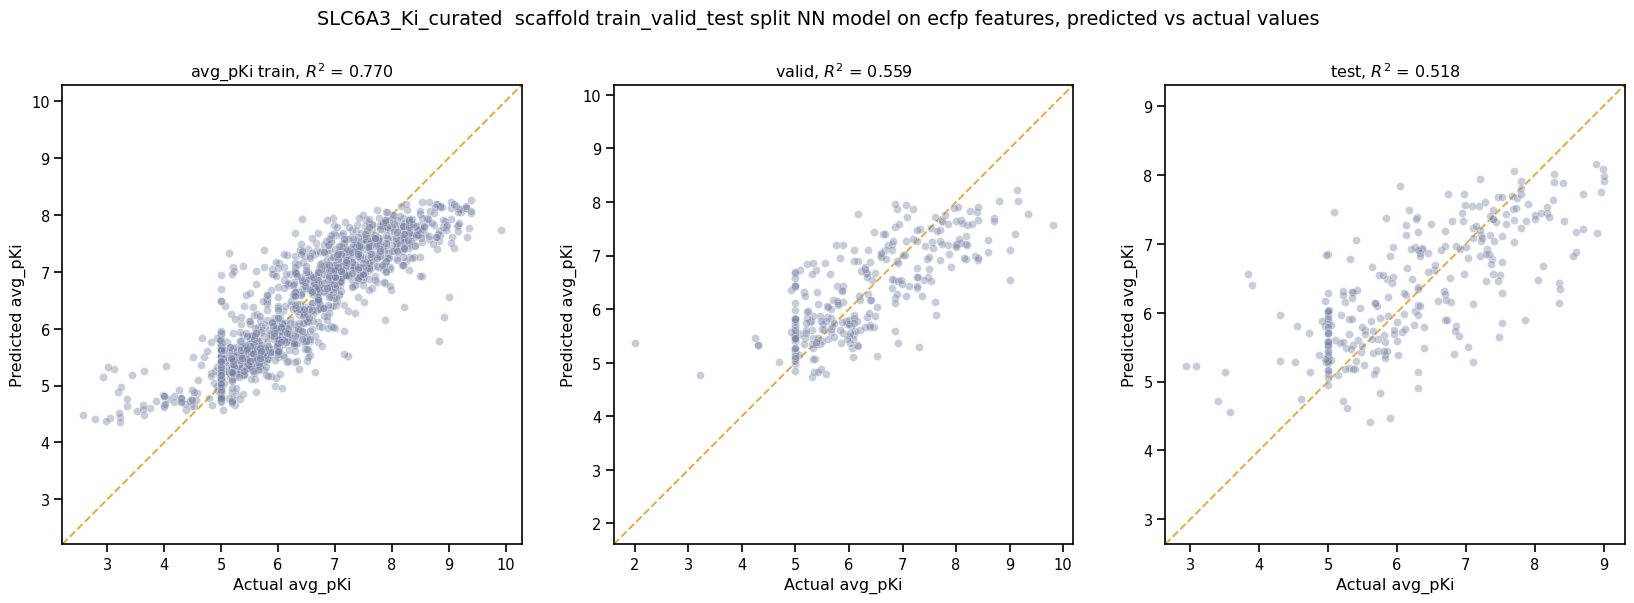

In [13]:
# plot best model, an NN
import importlib
importlib.reload(pp)
model_path=result_df.iloc[0].model_path
pp.plot_pred_vs_actual_from_file(model_path)

### Trying to identify the differences

In [7]:
# Load libraries
import os

import matplotlib

import sys
import tempfile
import tarfile
import json
import pandas as pd
import numpy as np
import seaborn as sns
import umap
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.mplot3d import Axes3D

from atomsci.ddm.utils import file_utils as futils
from atomsci.ddm.pipeline import perf_data as perf
from atomsci.ddm.pipeline import predict_from_model as pfm

#matplotlib.style.use('ggplot')
matplotlib.rc('xtick', labelsize=12)
matplotlib.rc('ytick', labelsize=12)
matplotlib.rc('axes', labelsize=12)


In [1]:
def plot_pred_vs_actual_from_file(model_path):
    """Plot predicted vs actual values from a trained regression model from a model tarball.

    Args:
        model_path (str): Path to an AMPL model tar.gz file.

    Returns:
        None

    Effects:
        A matplotlib figure is displayed with subplots for each response column and train/valid/test subsets.

    """
    # reload model
    reload_dir = tempfile.mkdtemp()
    with tarfile.open(model_path, mode='r:gz') as tar:
        futils.safe_extract(tar, path=reload_dir)
    
    # reload metadata
    with open(os.path.join(reload_dir, 'model_metadata.json')) as f:
        config=json.loads(f.read())
    
    # load (featurized) data
    dataset_dict=config['training_dataset']
    dataset_key=dataset_dict['dataset_key']
    is_featurized=False
    AD_method=None
    if config['model_parameters']['featurizer'] in ['descriptors','computed_descriptors']:
        desc=config['descriptor_specific']['descriptor_type']
        dataset_key=dataset_key.rsplit('/', maxsplit=1)
        dataset_key=os.path.join(dataset_key[0], 'scaled_descriptors', dataset_key[1].replace('.csv',f'_with_{desc}_descriptors.csv'))
        is_featurized=True
    if config['model_parameters']['featurizer'] != 'graphconv':
        AD_method='z_score'
    df=pd.read_csv(dataset_key)
    
    # reload split file
    dataset_key=dataset_dict['dataset_key']
    split_dict=config['splitting_parameters']
    split_file=dataset_key.replace('.csv',f"_{split_dict['split_strategy']}_{split_dict['splitter']}_{split_dict['split_uuid']}.csv")
    split=pd.read_csv(split_file)
    split=split.rename(columns={'cmpd_id':dataset_dict['id_col']})
    
    # merge
    df=df.merge(split, how='left')
    
    # get other values
    response_cols=dataset_dict['response_cols']
    
    # run predictions
    pred_df=pfm.predict_from_model_file(model_path, df, id_col=dataset_dict['id_col'], smiles_col=dataset_dict['smiles_col'], 
                                        response_col=response_cols, is_featurized=is_featurized, AD_method=AD_method, dont_standardize=True)                              
    
    # plot
    sns.set_context('notebook')
    fig, ax = plt.subplots(len(response_cols),3,sharey=True,sharex=True,figsize=(10*len(response_cols),30))
    if len(response_cols)>1:
        for i,resp in enumerate(response_cols):
            for j, subs in enumerate(['train','valid','test']):
                tmp=pred_df[pred_df.subset==subs]
                plot_pred_vs_actual_from_df(tmp, actual_col=f'{resp}_actual', pred_col=f'{resp}_pred', label=f'{resp} {subs}', ax=ax[i,j])
    else:
        resp=response_cols[0]
        for j, subs in enumerate(['train','valid','test']):
            tmp=pred_df[pred_df.subset==subs]
            plot_pred_vs_actual_from_df(tmp, actual_col=f'{resp}_actual', pred_col=f'{resp}_pred', label=subs, ax=ax[j])
    # fig.suptitle(f'Predicted vs Actual values for {resp} model', y=1.05)


The 1.6.0 implementation of `plot_pred_vs_actual_from_df` did not work. Below is an adjusted version of 1.6.1 to make it somewhat identical.


Most of the changes occur in `plot_pred_vs_actual_from_df`. The `alpha=0.4` in `g=sns.scatterplot` makes the dots more opaque. However, with this commented out, it looks the same. Similarly, we can change the `g.ploy(lims...` function to set the line to be red and not dashed. 

In [11]:
def plot_pred_vs_actual_from_df(pred_df, actual_col='avg_pIC50_actual', pred_col='avg_pIC50_pred', label=None, ax=None):
    """Plot predicted vs actual values from a trained regression model for a given dataframe.

    Args:
        pred_df (Pandas.DataFrame): A dataframe containing predicted and actual values for each compound.

        actual_col (str): Column with actual values.

        pred_col (str): Column with predicted values.

        label (str): Descriptive label for the plot.

        ax (matplotlib.axes.Axes): Optional, an axes object to plot onto. If None, one is created.

    Returns:
        g (matplotlib.axes.Axes): The axes object with data.

    """
    g=sns.scatterplot(x=actual_col, y=pred_col, data=pred_df, ax=ax) #, alpha=0.4
    lims = [
        pred_df[[actual_col,pred_col]].min().min(),  # min of both axes
        pred_df[[actual_col,pred_col]].max().max(),  # max of both axes
    ]
    margin=(lims[1]-lims[0])*0.05
    lims=[lims[0]-margin,lims[1]+margin]
    #g.plot(lims, lims, 'r-', alpha=0.75, zorder=0)
    # Draw an identity line
    g.plot(lims, lims, c=test_col, linestyle='--', alpha=0.75, zorder=0)
    # plt.gca().set_aspect('equal', adjustable='box')
    g.set_aspect('equal')
    g.set_xlim(lims)
    g.set_ylim(lims)
    g.set_title(label)
    return g

In [4]:
# Map train/valid/test categories to colors and shades
sat_cols = sns.color_palette('colorblind').as_hex()
train_col = sat_cols[0]
valid_col = sat_cols[2]
test_col = sat_cols[1]
full_col = sat_cols[4]

shade_cols = sns.color_palette('pastel').as_hex()
train_shade = shade_cols[0]
valid_shade = shade_cols[2]
test_shade = shade_cols[1]

# Map boolean distinctions (false/true, incorrect/correct, etc.) to colors from 'colorblind' palette
binary_pal = {0 : sat_cols[3], 1 : sat_cols[0]}

# Map combined split subset / activity categories to colors from 'colorblind' palette
train_active_col = sat_cols[0]
train_inactive_col = sat_cols[9]
test_active_col = sat_cols[3]
test_inactive_col = sat_cols[2]

# Use sequential 'crest' palette, which runs from light green to dark blue, for continuous values
continuous_pal = sns.color_palette('crest', as_cmap=True)

2024-05-28 13:24:50,341 dataset/SLC6A3_models/SLC6A3_Ki_curated_model_b24a2887-8eca-43e2-8fc2-3642189d2c94.tar.gz, 1.6.0
2024-05-28 13:24:50,343 Version compatible check: dataset/SLC6A3_models/SLC6A3_Ki_curated_model_b24a2887-8eca-43e2-8fc2-3642189d2c94.tar.gz version = "1.6", AMPL version = "1.6"


['/var/folders/rf/_d6b2mgd3p9f422kk977zjlh0000gn/T/tmpmy1v0t87/best_model/checkpoint1.pt']
/var/folders/rf/_d6b2mgd3p9f422kk977zjlh0000gn/T/tmpmy1v0t87/best_model/checkpoint1.pt


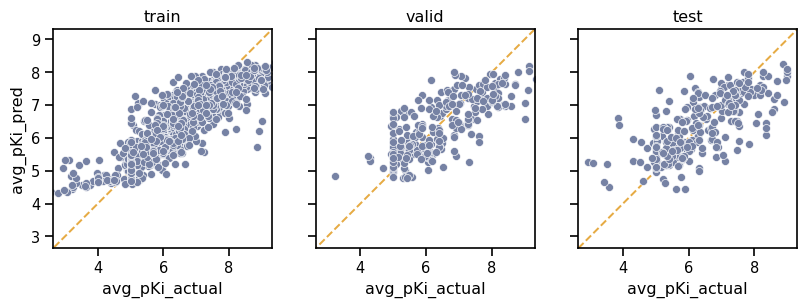

In [12]:
# plot best model, an NN
import importlib
#importlib.reload(pp)
model_path=result_df.iloc[0].model_path
plot_pred_vs_actual_from_file(model_path)

## Narrow down what's changing the dot size

In [3]:
## Version from 1.6.1
def plot_pred_vs_actual_from_file(model_path, external_training_data=None, plot_size=7):
    """Plot predicted vs actual values from a trained regression model from a model tarball. 
    This function only works for locally trained models; otherwise see the `predict_from_model` module.

    Args:
        model_path (str): Path to an AMPL model tar.gz file.
        external_training_data (str): Path to copy of training dataset, if different from path used when model was trained.
        plot_size (float): Height of subplots

    Returns:
        None

    Effects:
        A matplotlib figure is displayed with subplots for each response column and train/valid/test subsets.

    """
    # reload model
    reload_dir = tempfile.mkdtemp()
    with tarfile.open(model_path, mode='r:gz') as tar:
        futils.safe_extract(tar, path=reload_dir)
    
    # reload metadata
    with open(os.path.join(reload_dir, 'model_metadata.json')) as f:
        config=json.loads(f.read())

    if config['model_parameters']['prediction_type']=='classification':
        raise ValueError("plot_pred_vs_actual_from_file() should only be called for regression models. Please try plot_confusion_matrices() instead.")
    
    # load (featurized) data
    dataset_dict=config['training_dataset']
    if external_training_data is not None:
        dataset_dict['dataset_key']=external_training_data
    dataset_key=dataset_dict['dataset_key']
    dataset_name = os.path.splitext(os.path.basename(dataset_key))[0]

    is_featurized=False
    AD_method=None
    model_type = config['model_parameters']['model_type']
    featurizer = config['model_parameters']['featurizer']
    if featurizer in ['descriptors','computed_descriptors']:
        desc=config['descriptor_specific']['descriptor_type']
        dataset_key=dataset_key.rsplit('/', maxsplit=1)
        dataset_key=os.path.join(dataset_key[0], 'scaled_descriptors', dataset_key[1].replace('.csv',f'_with_{desc}_descriptors.csv'))
        is_featurized=True
        features_label = f"{desc} descriptors"
    else:
        features_label = f"{featurizer} features"
    if config['model_parameters']['featurizer'] != 'graphconv':
        AD_method='z_score'
    df=pd.read_csv(dataset_key)
    
    # reload split file
    dataset_key=dataset_dict['dataset_key']
    split_dict=config['splitting_parameters']
    splitter = split_dict['splitter']
    split_strategy = split_dict['split_strategy']
    if split_strategy == 'k_fold_cv':
        split_file=dataset_key.replace('.csv',f"_{split_dict['num_folds']}_fold_cv_{splitter}_{split_dict['split_uuid']}.csv")
        split_subsets = ['train_valid', 'test']
    else:
        split_file=dataset_key.replace('.csv',f"_{split_strategy}_{splitter}_{split_dict['split_uuid']}.csv")
        split_subsets = ['train', 'valid', 'test']
    split=pd.read_csv(split_file)
    split=split.rename(columns={'cmpd_id':dataset_dict['id_col']})
    
    # merge
    df=df.merge(split, how='left')
    
    # get other values
    response_cols=dataset_dict['response_cols']
    
    # run predictions
    pred_df=pfm.predict_from_model_file(model_path, df, id_col=dataset_dict['id_col'], smiles_col=dataset_dict['smiles_col'], 
                                        response_col=response_cols, is_featurized=is_featurized, AD_method=AD_method, dont_standardize=True)          
    
    # plot
    sns.set_context('notebook')
    nss = len(split_subsets)
    fig, axes = plt.subplots(len(response_cols), nss, figsize=(plot_size*nss, plot_size*len(response_cols))) 
    # to the above sharey=True, sharex=True was also added 
    suptitle = f"{dataset_name}  {splitter} {split_strategy} split {model_type} model on {features_label}, predicted vs actual values"
    fig.suptitle(suptitle, y=0.95)
    axes = axes.flatten()
    for i,resp in enumerate(response_cols):
        actual_col = f'{resp}_actual'
        pred_col = f'{resp}_pred'
        task_pred_df = pred_df[pred_df[actual_col].notna() & pred_df[pred_col].notna()]
        y_actual = task_pred_df[actual_col].values
        y_pred = task_pred_df[pred_col].values
        ymin = min(min(y_actual), min(y_pred))
        ymax = max(max(y_actual), max(y_pred))
        for j, subset in enumerate(split_subsets):
            ax = axes[nss*i + j]
            # Force axes to have same scale for all subsets for same task (but not different tasks!)
            ax.set_xlim(ymin, ymax)
            ax.set_ylim(ymin, ymax)
            tmp = task_pred_df[task_pred_df.subset==subset]
            r2 = metrics.r2_score(tmp[actual_col].values, tmp[pred_col].values)
            ax.set_xlabel(f"Actual {resp}")
            ax.set_ylabel(f"Predicted {resp}")
            # Set subplot title
            if j == 0:
                subtitle = f"{resp} {subset}, {score_type_label['r2']} = {r2:.3f}"
            else:
                subtitle = f"{subset}, {score_type_label['r2']} = {r2:.3f}"
            plot_pred_vs_actual_from_df(tmp, actual_col=actual_col, pred_col=pred_col, label=subtitle, ax=ax)



In [4]:
## 1.6.1 adapted 
def plot_pred_vs_actual_from_df(pred_df, actual_col='avg_pIC50_actual', pred_col='avg_pIC50_pred', label=None, ax=None):
    """Plot predicted vs actual values from a trained regression model for a given dataframe.

    Args:
        pred_df (Pandas.DataFrame): A dataframe containing predicted and actual values for each compound.

        actual_col (str): Column with actual values.

        pred_col (str): Column with predicted values.

        label (str): Descriptive label for the plot.

        ax (matplotlib.axes.Axes): Optional, an axes object to plot onto. If None, one is created.

    Returns:
        g (matplotlib.axes.Axes): The axes object with data.

    """
    g=sns.scatterplot(x=actual_col, y=pred_col, data=pred_df, ax=ax) #, alpha=0.4
    lims = [
        pred_df[[actual_col,pred_col]].min().min(),  # min of both axes
        pred_df[[actual_col,pred_col]].max().max(),  # max of both axes
    ]
    margin=(lims[1]-lims[0])*0.05
    lims=[lims[0]-margin,lims[1]+margin]
    #g.plot(lims, lims, 'r-', alpha=0.75, zorder=0)
    # Draw an identity line
    g.plot(lims, lims, c=test_col, linestyle='--', alpha=0.75, zorder=0)
    # plt.gca().set_aspect('equal', adjustable='box')
    g.set_aspect('equal')
    g.set_xlim(lims)
    g.set_ylim(lims)
    g.set_title(label)
    return g

In [8]:
# 1.6.1 
# Map train/valid/test categories to colors and shades
sat_cols = sns.color_palette('colorblind').as_hex()
train_col = sat_cols[0]
valid_col = sat_cols[2]
test_col = sat_cols[1]
full_col = sat_cols[4]

shade_cols = sns.color_palette('pastel').as_hex()
train_shade = shade_cols[0]
valid_shade = shade_cols[2]
test_shade = shade_cols[1]

# Map boolean distinctions (false/true, incorrect/correct, etc.) to colors from 'colorblind' palette
binary_pal = {0 : sat_cols[3], 1 : sat_cols[0]}

# Map combined split subset / activity categories to colors from 'colorblind' palette
train_active_col = sat_cols[0]
train_inactive_col = sat_cols[9]
test_active_col = sat_cols[3]
test_inactive_col = sat_cols[2]

# Use sequential 'crest' palette, which runs from light green to dark blue, for continuous values
continuous_pal = sns.color_palette('crest', as_cmap=True)

In [5]:
score_type_label = dict(r2 = '$R^2$', mae = 'MAE', rmse = 'RMSE',
        roc_auc = 'ROC AUC', precision = 'Precision', ppv = 'Precision', recall = 'Recall',
        npv = 'NPV', cross_entropy = 'Cross entropy', accuracy = 'Accuracy', bal_accuracy = 'Balanced accuracy',
        avg_precision = 'Average precision', prc_auc = 'Average precision', 
        MCC = 'Matthews corr coef', mcc = 'Matthews corr coef', kappa = "Cohen's kappa")


2024-05-28 13:43:26,499 dataset/SLC6A3_models/SLC6A3_Ki_curated_model_b24a2887-8eca-43e2-8fc2-3642189d2c94.tar.gz, 1.6.0
2024-05-28 13:43:26,503 Version compatible check: dataset/SLC6A3_models/SLC6A3_Ki_curated_model_b24a2887-8eca-43e2-8fc2-3642189d2c94.tar.gz version = "1.6", AMPL version = "1.6"


['/var/folders/rf/_d6b2mgd3p9f422kk977zjlh0000gn/T/tmpu6uaeuaj/best_model/checkpoint1.pt']
/var/folders/rf/_d6b2mgd3p9f422kk977zjlh0000gn/T/tmpu6uaeuaj/best_model/checkpoint1.pt


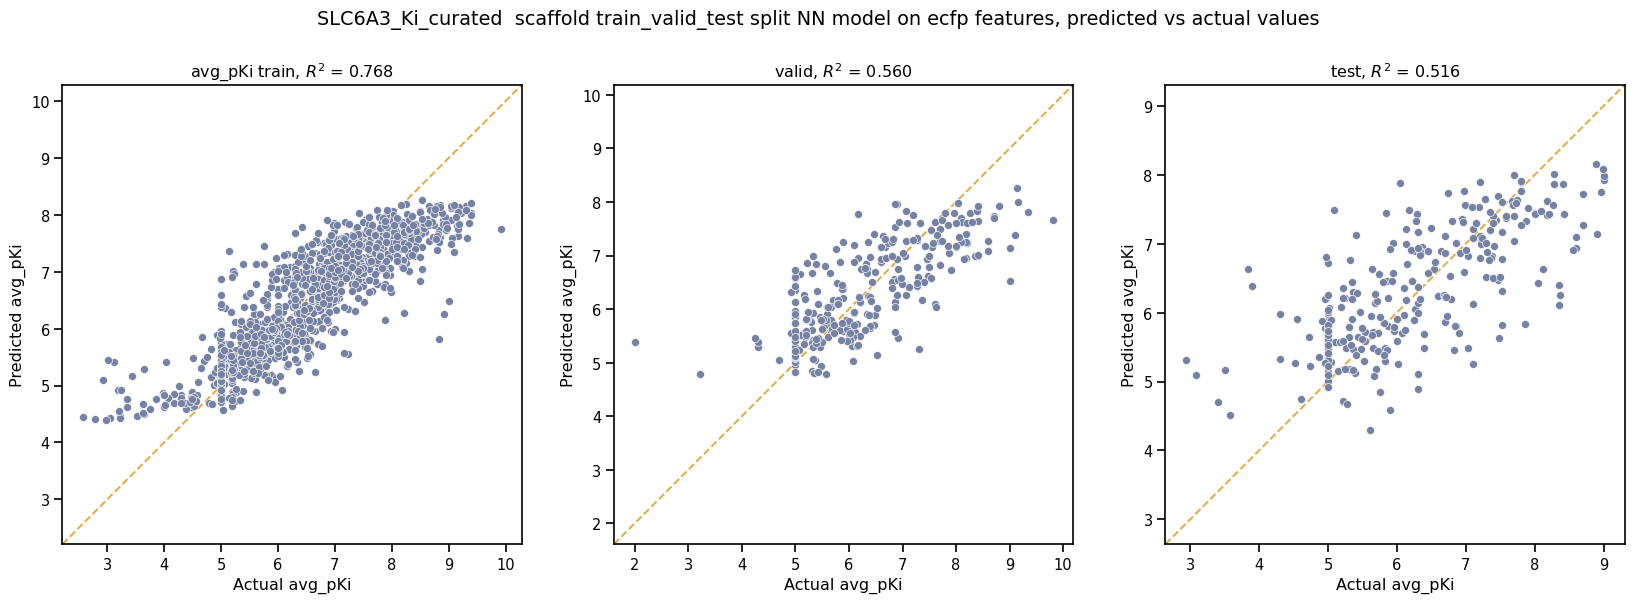

In [9]:
# from the first run using the 1.6.1 slightly altered appearance (plot size: figsize=(plot_size*nss, plot_size*len(response_cols)))
# plot size =
# plot best model, an NN
import importlib
#importlib.reload(pp)
model_path=result_df.iloc[0].model_path
plot_pred_vs_actual_from_file(model_path)

### Changing only the figsize in `plot_pred_vs_actual_from_file`

In [22]:
## Version from 1.6.1
def plot_pred_vs_actual_from_file(model_path, external_training_data=None, plot_size=7):
    """Plot predicted vs actual values from a trained regression model from a model tarball. 
    This function only works for locally trained models; otherwise see the `predict_from_model` module.

    Args:
        model_path (str): Path to an AMPL model tar.gz file.
        external_training_data (str): Path to copy of training dataset, if different from path used when model was trained.
        plot_size (float): Height of subplots

    Returns:
        None

    Effects:
        A matplotlib figure is displayed with subplots for each response column and train/valid/test subsets.

    """
    # reload model
    reload_dir = tempfile.mkdtemp()
    with tarfile.open(model_path, mode='r:gz') as tar:
        futils.safe_extract(tar, path=reload_dir)
    
    # reload metadata
    with open(os.path.join(reload_dir, 'model_metadata.json')) as f:
        config=json.loads(f.read())

    if config['model_parameters']['prediction_type']=='classification':
        raise ValueError("plot_pred_vs_actual_from_file() should only be called for regression models. Please try plot_confusion_matrices() instead.")
    
    # load (featurized) data
    dataset_dict=config['training_dataset']
    if external_training_data is not None:
        dataset_dict['dataset_key']=external_training_data
    dataset_key=dataset_dict['dataset_key']
    dataset_name = os.path.splitext(os.path.basename(dataset_key))[0]

    is_featurized=False
    AD_method=None
    model_type = config['model_parameters']['model_type']
    featurizer = config['model_parameters']['featurizer']
    if featurizer in ['descriptors','computed_descriptors']:
        desc=config['descriptor_specific']['descriptor_type']
        dataset_key=dataset_key.rsplit('/', maxsplit=1)
        dataset_key=os.path.join(dataset_key[0], 'scaled_descriptors', dataset_key[1].replace('.csv',f'_with_{desc}_descriptors.csv'))
        is_featurized=True
        features_label = f"{desc} descriptors"
    else:
        features_label = f"{featurizer} features"
    if config['model_parameters']['featurizer'] != 'graphconv':
        AD_method='z_score'
    df=pd.read_csv(dataset_key)
    
    # reload split file
    dataset_key=dataset_dict['dataset_key']
    split_dict=config['splitting_parameters']
    splitter = split_dict['splitter']
    split_strategy = split_dict['split_strategy']
    if split_strategy == 'k_fold_cv':
        split_file=dataset_key.replace('.csv',f"_{split_dict['num_folds']}_fold_cv_{splitter}_{split_dict['split_uuid']}.csv")
        split_subsets = ['train_valid', 'test']
    else:
        split_file=dataset_key.replace('.csv',f"_{split_strategy}_{splitter}_{split_dict['split_uuid']}.csv")
        split_subsets = ['train', 'valid', 'test']
    split=pd.read_csv(split_file)
    split=split.rename(columns={'cmpd_id':dataset_dict['id_col']})
    
    # merge
    df=df.merge(split, how='left')
    
    # get other values
    response_cols=dataset_dict['response_cols']
    
    # run predictions
    pred_df=pfm.predict_from_model_file(model_path, df, id_col=dataset_dict['id_col'], smiles_col=dataset_dict['smiles_col'], 
                                        response_col=response_cols, is_featurized=is_featurized, AD_method=AD_method, dont_standardize=True)          
    
    # plot
    sns.set_context('notebook')
    nss = len(split_subsets)
    fig, axes = plt.subplots(len(response_cols), nss, figsize=(10*len(response_cols), 30)) #figsize=(plot_size*nss, plot_size*len(response_cols))
    # to the above sharey=True, sharex=True was also added 
    suptitle = f"{dataset_name}  {splitter} {split_strategy} split {model_type} model on {features_label}, predicted vs actual values"
    fig.suptitle(suptitle, y=0.55) # was 0.95, adjusted to make the plot less long 
    axes = axes.flatten()
    for i,resp in enumerate(response_cols):
        actual_col = f'{resp}_actual'
        pred_col = f'{resp}_pred'
        task_pred_df = pred_df[pred_df[actual_col].notna() & pred_df[pred_col].notna()]
        y_actual = task_pred_df[actual_col].values
        y_pred = task_pred_df[pred_col].values
        ymin = min(min(y_actual), min(y_pred))
        ymax = max(max(y_actual), max(y_pred))
        for j, subset in enumerate(split_subsets):
            ax = axes[nss*i + j]
            # Force axes to have same scale for all subsets for same task (but not different tasks!)
            ax.set_xlim(ymin, ymax)
            ax.set_ylim(ymin, ymax)
            tmp = task_pred_df[task_pred_df.subset==subset]
            r2 = metrics.r2_score(tmp[actual_col].values, tmp[pred_col].values)
            ax.set_xlabel(f"Actual {resp}")
            ax.set_ylabel(f"Predicted {resp}")
            # Set subplot title
            if j == 0:
                subtitle = f"{resp} {subset}, {score_type_label['r2']} = {r2:.3f}"
            else:
                subtitle = f"{subset}, {score_type_label['r2']} = {r2:.3f}"
            plot_pred_vs_actual_from_df(tmp, actual_col=actual_col, pred_col=pred_col, label=subtitle, ax=ax)



2024-05-28 13:47:00,431 dataset/SLC6A3_models/SLC6A3_Ki_curated_model_b24a2887-8eca-43e2-8fc2-3642189d2c94.tar.gz, 1.6.0
2024-05-28 13:47:00,434 Version compatible check: dataset/SLC6A3_models/SLC6A3_Ki_curated_model_b24a2887-8eca-43e2-8fc2-3642189d2c94.tar.gz version = "1.6", AMPL version = "1.6"


['/var/folders/rf/_d6b2mgd3p9f422kk977zjlh0000gn/T/tmpkptu7l_e/best_model/checkpoint1.pt']
/var/folders/rf/_d6b2mgd3p9f422kk977zjlh0000gn/T/tmpkptu7l_e/best_model/checkpoint1.pt


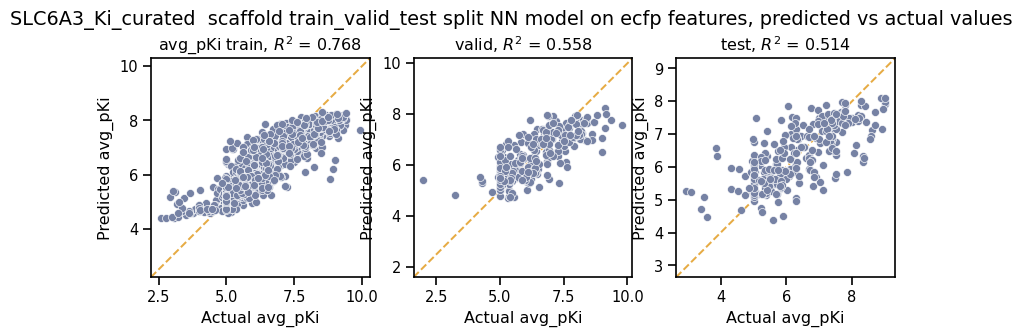

In [23]:
# from the second run using 1.6.0 version plot size (figsize=(10*len(response_cols), 30))
import importlib
#importlib.reload(pp)
model_path=result_df.iloc[0].model_path
plot_pred_vs_actual_from_file(model_path)

Looks like the figsize is potentially the cause of the difference in dot size. The other differences in the plot (axes titles, opaqueness of the dots, line color, title, etc.) can all be changed. 